# Generate plots for tedana workflow

In [1]:
%matplotlib inline
import os.path as op
from glob import glob

import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from nilearn.masking import apply_mask
from sklearn.decomposition import PCA, FastICA

In [2]:
ted_dir = op.abspath('../sandbox/TED.p06/')
mask_file = op.join(ted_dir, 'mask.nii')
oc_file = op.join(ted_dir, 'tsoc_orig.nii')
oc_red_file = op.join(ted_dir, 'tsoc_reduced.nii')
t2s_file = op.join(ted_dir, 't2sv.nii')
mepca_mmix_file = op.join(ted_dir, 'mepca_mix.1D')
meica_mmix_file = op.join(ted_dir, 'meica_mix.1D')
weights_file = op.join(ted_dir, 'ica_model_metric_weights.nii')
mepca_betas_file = op.join(ted_dir, 'pca_model_betas_catd.nii')
meica_betas_file = op.join(ted_dir, 'ica_model_betas_catd.nii')
meica_f_r2_file = op.join(ted_dir, 'ica_model_F_R2.nii')
meica_f_s0_file = op.join(ted_dir, 'ica_model_F_S0.nii')
r2_pred_file = op.join(ted_dir, 'ica_model_R2_pred.nii')
s0_pred_file = op.join(ted_dir, 'ica_model_S0_pred.nii')

dn_file = op.join(ted_dir, 'dn_ts_OC.nii')
hk_file = op.join(ted_dir, 'hik_ts_OC.nii')

dn_t1c_file = op.join(ted_dir, 'dn_ts_OC_T1c.nii')
hk_t1c_file = op.join(ted_dir, 'hik_ts_OC_T1c.nii')

oc = apply_mask(oc_file, mask_file)
oc_z = (oc - np.mean(oc, axis=0)) / np.std(oc, axis=0)

data_dir = '/Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/'
files = ['p06.SBJ01_S09_Task11_e1.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e2.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e3.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e4.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e5.sm.nii.gz']
echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])
files = [op.join(data_dir, f) for f in files]
masked_data = [apply_mask(f, mask_file) for f in files]
masked_data = np.stack(masked_data)
masked_data = np.swapaxes(np.swapaxes(masked_data, 0, 2), 1, 2)

t2smap = apply_mask(t2s_file, mask_file)

mepca_mmix = np.loadtxt(mepca_mmix_file)
oc_red = apply_mask(oc_red_file, mask_file)  # PCA-whitened OC data

meica_mmix = np.loadtxt(meica_mmix_file)

norm_weights = apply_mask(weights_file, mask_file)
meica_betas = apply_mask(meica_betas_file, mask_file)
meica_f_r2 = apply_mask(meica_f_r2_file, mask_file)
meica_f_s0 = apply_mask(meica_f_s0_file, mask_file)
meica_f_r2[meica_f_r2 > 500] = 500
meica_f_s0[meica_f_s0 > 500] = 500

r2_pred_betas = apply_mask(r2_pred_file, mask_file)
s0_pred_betas = apply_mask(s0_pred_file, mask_file)

dn_data = apply_mask(dn_file, mask_file)
hk_data = apply_mask(hk_file, mask_file)

dn_t1c_data = apply_mask(dn_t1c_file, mask_file)
hk_t1c_data = apply_mask(hk_t1c_file, mask_file)

# Get index of selected voxel
mask_img = nib.load(mask_file)
temp_data = np.zeros(mask_img.shape)
temp_data[20, 25, 14] = 1
temp_img = nib.Nifti1Image(temp_data, mask_img.affine)
temp_data = apply_mask(temp_img, mask_img)
voxel_idx = np.where(temp_data == 1)[0][0]

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


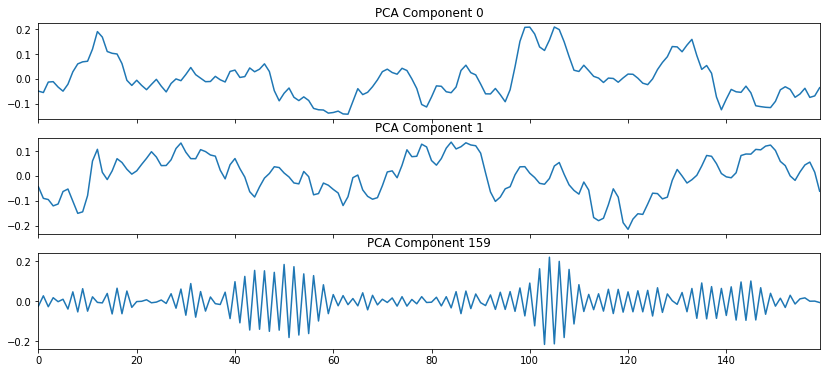

In [3]:
# Optimally combined data are decomposed with PCA
# PCA components are retained according to a
# decision tree or a variance explained threshold
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(mepca_mmix[:, 0])
axes[0].set_title('PCA Component 0')
axes[1].plot(mepca_mmix[:, 1])
axes[1].set_title('PCA Component 1')
axes[2].plot(mepca_mmix[:, -1])
axes[2].set_title('PCA Component {}'.format(mepca_mmix.shape[0]-1))
axes[0].set_xlim(0, mepca_mmix.shape[0]-1)
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


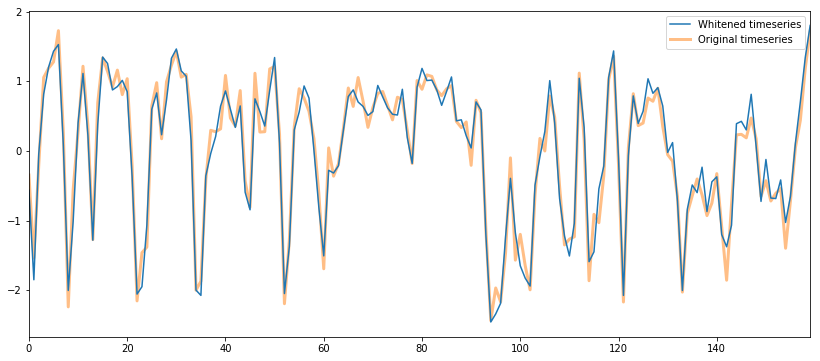

In [4]:
# A whitened version of the optimally combined data is generated by
# combining the retained PCA components only
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(oc_red[:, voxel_idx], label='Whitened timeseries', zorder=1.)
ax.plot(oc_z[:, voxel_idx], label='Original timeseries', alpha=0.5, zorder=0., linewidth=3)
legend = ax.legend(frameon=True)
ax.set_xlim(0, oc_z.shape[0]-1)
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


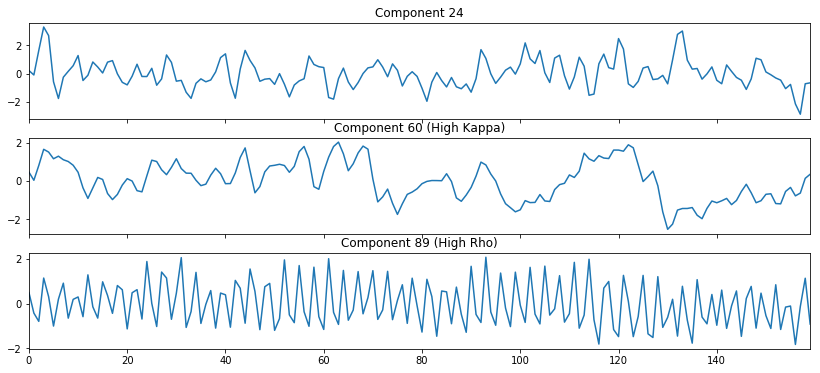

In [5]:
# Whitened optimally combined data are decomposed with ICA
# ICA generates a mixing matrix (timeseries for each component)
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(meica_mmix[:, 24])
axes[0].set_title('Component 24')
axes[1].plot(meica_mmix[:, 60])
axes[1].set_title('Component 60 (High Kappa)')
axes[2].plot(meica_mmix[:, 89])
axes[2].set_title('Component 89 (High Rho)')
axes[0].set_xlim(0, meica_mmix.shape[0]-1)
fig.show()

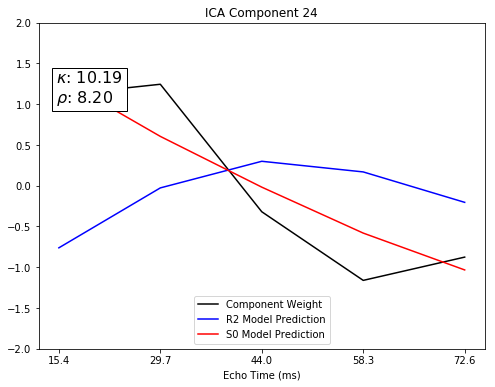

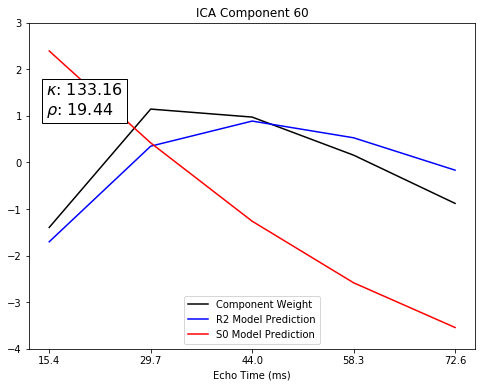

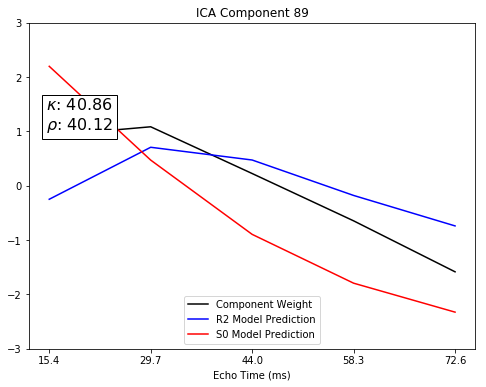

In [6]:
# We use linear regression to fit the component timeseries
# to each voxel in each echo from the original data
# This results in echo- and voxel-specific betas for
# each of the components
# We can then fit TE-dependence (R2) and TE-independence (S0)
# models to these betas
# These models allow calculation of F-statistics for the
# R2 and S0 models (kappa and rho, respectively)
ks, rs = [], []
for i_comp in range(meica_mmix.shape[1]):
    #comp_weights = np.mean(meica_betas[i_comp, :, :], axis=1)
    #r2_pred_weights = np.mean(r2_pred_betas[i_comp, :, :], axis=1)
    #s0_pred_weights = np.mean(s0_pred_betas[i_comp, :, :], axis=1)
    #k = np.mean(meica_f_r2[i_comp, :])
    #r = np.mean(meica_f_s0[i_comp, :])

    # Use weight map to average as fitmodels_direct does
    comp_weights = np.average(meica_betas[i_comp, :, :], weights=norm_weights[i_comp, :], axis=1)
    r2_pred_weights = np.average(r2_pred_betas[i_comp, :, :], weights=norm_weights[i_comp, :], axis=1)
    s0_pred_weights = np.average(s0_pred_betas[i_comp, :, :], weights=norm_weights[i_comp, :], axis=1)
    k = np.average(meica_f_r2[i_comp, :], weights=norm_weights[i_comp, :])
    r = np.average(meica_f_s0[i_comp, :], weights=norm_weights[i_comp, :])
    
    ks.append(k)
    rs.append(r)
    
    mean_ = np.mean(comp_weights)
    std_ = np.std(comp_weights)
    comp_weights_z = (comp_weights - mean_) / std_
    s0_pred_weights_z = (s0_pred_weights - mean_) / std_
    r2_pred_weights_z = (r2_pred_weights - mean_) / std_

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(echo_times, comp_weights_z, color='black', label='Component Weight')
    ax.plot(echo_times, r2_pred_weights_z, color='blue', label='R2 Model Prediction')
    ax.plot(echo_times, s0_pred_weights_z, color='red', label='S0 Model Prediction')
    ax.set_xticks(echo_times)
    ax.set_xlabel('Echo Time (ms)')
    temp = np.hstack((comp_weights_z, s0_pred_weights_z, r2_pred_weights_z))
    ax.set_ylim(np.floor(np.min(temp)), np.ceil(np.max(temp)))
    legend = ax.legend(frameon=True, loc='lower center')
    ax.set_title('ICA Component {}'.format(i_comp))
    ax.annotate('$\kappa$: {0:.02f}\n$\\rho$: {1:.02f}'.format(k, r),
                xy=(15, 1), fontsize=16,
                bbox=dict(fc="white", ec="black", lw=1))

    fig.savefig('bold_models_component_{}.png'.format(i_comp), dpi=400)
    if i_comp not in [24, 60, 89]:
        plt.close()

In [7]:
# A decision tree is applied to Kappa, Rho, and other metrics
# in order to classify ICA components as TE-dependent (BOLD),
# TE-independent (non-BOLD noise), or neither (to be ignored).

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


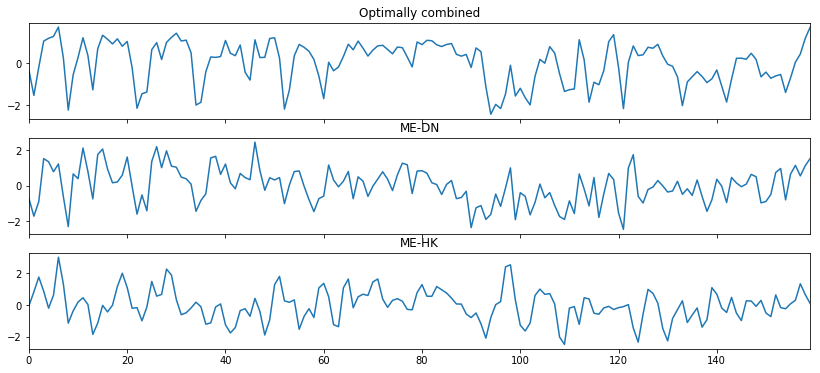

In [8]:
# The ME-DN dataset is constructed from the BOLD and ignored components.
# The ME-HK dataset is constructed just from the BOLD components.
dn_data_z = (dn_data - np.mean(dn_data, axis=0)) / np.std(dn_data, axis=0)
hk_data_z = (hk_data - np.mean(hk_data, axis=0)) / np.std(hk_data, axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(oc_z[:, voxel_idx], label='Optimally combined')
axes[0].set_title('Optimally combined')

axes[1].plot(dn_data_z[:, voxel_idx], label='ME-DN')
axes[1].set_title('ME-DN')

axes[2].plot(hk_data_z[:, voxel_idx])
axes[2].set_title('ME-HK')
legend = ax.legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


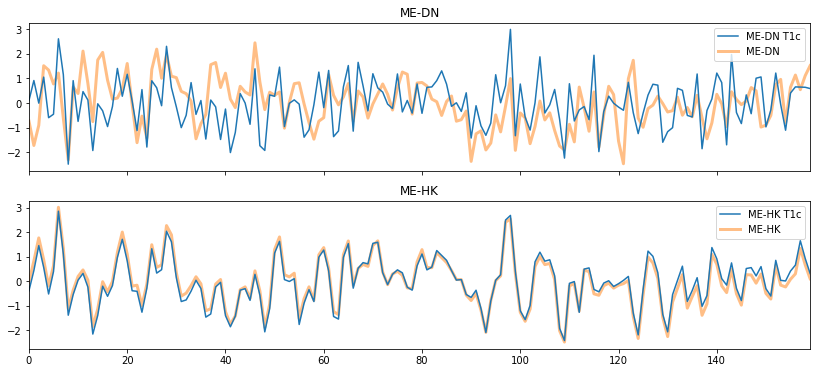

In [9]:
# Post-processing (e.g., T1c-GSR) may be applied to either dataset
# in order to remove spatially diffuse (ostensibly respiration-related)
# noise
dn_t1c_data_z = (dn_t1c_data - np.mean(dn_t1c_data, axis=0)) / np.std(dn_t1c_data, axis=0)
hk_t1c_data_z = (hk_t1c_data - np.mean(hk_t1c_data, axis=0)) / np.std(hk_t1c_data, axis=0)

fig, axes = plt.subplots(2, sharex=True, figsize=(14, 6))
axes[0].plot(dn_t1c_data_z[:, voxel_idx], label='ME-DN T1c')
axes[0].plot(dn_data_z[:, voxel_idx], label='ME-DN', alpha=0.5, linewidth=3, zorder=0.)
axes[0].set_title('ME-DN')
legend = axes[0].legend(frameon=True, loc='upper right')

axes[1].plot(hk_t1c_data_z[:, voxel_idx], label='ME-HK T1c')
axes[1].plot(hk_data_z[:, voxel_idx], label='ME-HK', alpha=0.5, linewidth=3, zorder=0.)
axes[1].set_title('ME-HK')
legend = axes[1].legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
fig.show()